In [ ]:
import queue #multi-producer, multi-consumer queues
import time # time execution

import numpy as np # numpy base
from numba import njit # just in time compiler
from tqdm.auto import tqdm # progress bar

from shap import Explanation, links # shap modules
from shap.models import Model
from shap.utils import MaskedModel, OpChain, make_masks, safe_isinstance
from shap.explainers._explainer import Explainer


class PartitionExplainer2(Explainer):
    """Uses the Partition SHAP method to explain the output of any function.

    Partition SHAP computes Shapley values recursively through a hierarchy of features, this
    hierarchy defines feature coalitions and results in the Owen  values from game theory.

    The PartitionExplainer has two particularly nice properties:

    1) PartitionExplainer is model-agnostic but when using a balanced partition tree only has
       quadratic exact runtime (in term of the number of input features). This is in contrast to the
       exponential exact runtime of KernelExplainer or SamplingExplainer.
    2) PartitionExplainer always assigns to groups of correlated features the credit that set of features
       would have had if treated as a group. This means if the hierarchical clustering given to
       PartitionExplainer groups correlated features together, then feature correlations are
       "accounted for" in the sense that the total credit assigned to a group of tightly dependent features
       does not depend on how they behave if their correlation structure was broken during the explanation's
       perturbation process.
    Note that for linear models the Owen values that PartitionExplainer returns are the same as the standard
    non-hierarchical Shapley values.
    """

    def __init__(self, model, masker, partition_tree = None, *, output_names=None, link=links.identity, linearize_link=True,
                 feature_names=None, **call_args):
        """Build a PartitionExplainer for the given model with the given masker.

        Parameters
        ----------
        model : function
            User supplied function that takes a matrix of samples (# samples x # features) and
            computes the output of the model for those samples.

        masker : function or numpy.array or pandas.DataFrame or tokenizer
            The function used to "mask" out hidden features of the form `masker(mask, x)`. It takes a
            single input sample and a binary mask and returns a matrix of masked samples. These
            masked samples will then be evaluated using the model function and the outputs averaged.
            As a shortcut for the standard masking using by SHAP you can pass a background data matrix
            instead of a function and that matrix will be used for masking. Domain specific masking
            functions are available in shap such as shap.maksers.Image for images and shap.maskers.Text
            for text.

        partition_tree : None or function or numpy.array ################################ NOT CURRENTLY IMPLEMENTED #####################################
            A hierarchical clustering of the input features represented by a matrix that follows the format
            used by scipy.cluster.hierarchy (see the notebooks_html/partition_explainer directory an example).
            If this is a function then the function produces a clustering matrix when given a single input
            example. If you are using a standard SHAP masker object then you can pass masker.clustering
            to use that masker's built-in clustering of the features, or if partition_tree is None then
            masker.clustering will be used by default.

        Examples
        --------
        See `Partition explainer examples <https://shap.readthedocs.io/en/latest/api_examples/explainers/PartitionExplainer.html>`_

        """
        super().__init__(model, masker,partition_tree = None, link=link, linearize_link=linearize_link, algorithm="partition", \
                         output_names = output_names, feature_names=feature_names)

        # convert dataframes
        # if isinstance(masker, pd.DataFrame):
        #     masker = TabularMasker(masker)
        # elif isinstance(masker, np.ndarray) and len(masker.shape) == 2:
        #     masker = TabularMasker(masker)
        # elif safe_isinstance(masker, "transformers.PreTrainedTokenizer"):
        #     masker = TextMasker(masker)
        # self.masker = masker

        # TODO: maybe? if we have a tabular masker then we build a PermutationExplainer that we
        # will use for sampling
        self.input_shape = masker.shape[1:] if hasattr(masker, "shape") and not callable(masker.shape) else None
        # self.output_names = output_names
        if not safe_isinstance(self.model, "shap.models.Model"):
            self.model = Model(self.model)#lambda *args: np.array(model(*args))
        self.expected_value = None
        self._curr_base_value = None
        if getattr(self.masker, "clustering", None) is None:
            raise ValueError("The passed masker must have a .clustering attribute defined! Try shap.maskers.Partition(data) for example.")

        ###########################
        # the rest of the partition tree use is not done
        ###########################

        if partition_tree is None:
            if not hasattr(masker, "partition_tree"):
                raise ValueError("The passed masker does not have masker.clustering, so the partition_tree must be passed!")
            self.partition_tree = masker.clustering
        else:
            if partition_tree 
            """
            check partition tree here 
            
            """
            self.partition_tree = partition_tree
            
            

        # handle higher dimensional tensor inputs
        if self.input_shape is not None and len(self.input_shape) > 1:
            self._reshaped_model = lambda x: self.model(x.reshape(x.shape[0], *self.input_shape))
        else:
            self._reshaped_model = self.model

        # if we don't have a dynamic clustering algorithm then can precowe mpute
        # a lot of information
        if not callable(self.masker.clustering):
            self._clustering = self.masker.clustering #
            self._mask_matrix = make_masks(self._clustering) # make masks argument

        # if we have gotten default arguments for the call function we need to wrap ourselves in a new class that
        # has a call function with those new default arguments
        if len(call_args) > 0:
            class PartitionExplainer(self.__class__):
                # this signature should match the __call__ signature of the class defined below
                def __call__(self, *args, max_evals=500, fixed_context=None, main_effects=False, error_bounds=False, batch_size="auto",
                             outputs=None, silent=False):
                    return super().__call__(
                        *args, max_evals=max_evals, fixed_context=fixed_context, main_effects=main_effects, error_bounds=error_bounds,
                        batch_size=batch_size, outputs=outputs, silent=silent
                    )
            PartitionExplainer.__call__.__doc__ = self.__class__.__call__.__doc__
            self.__class__ = PartitionExplainer
            for k, v in call_args.items():
                self.__call__.__kwdefaults__[k] = v

    # note that changes to this function signature should be copied to the default call argument wrapper above
    def __call__(self, *args, max_evals=500, fixed_context=None, main_effects=False, error_bounds=False, batch_size="auto",
                 outputs=None, silent=False):
        """Explain the output of the model on the given arguments."""
        return super().__call__(
            *args, max_evals=max_evals, fixed_context=fixed_context, main_effects=main_effects, error_bounds=error_bounds, batch_size=batch_size,
            outputs=outputs, silent=silent
        )

    def explain_row(self, *row_args, max_evals, main_effects, error_bounds, batch_size, outputs, silent, fixed_context = "auto"):
        """Explains a single row and returns the tuple (row_values, row_expected_values, row_mask_shapes)."""
        if fixed_context == "auto":
            # if isinstance(self.masker, maskers.Text):
            #     fixed_context = 1 # we err on the side of speed for text models
            # else:
            fixed_context = None
        elif fixed_context not in [0, 1, None]:
            raise ValueError("Unknown fixed_context value passed (must be 0, 1 or None): %s" %fixed_context) # fixes fixed context

        # build a masked versio  of the model for the current input sample
        fm = MaskedModel(self.model, self.masker, self.link, self.linearize_link, *row_args)

        # make sure we have the base value and current value outputs
        M = len(fm)
        m00 = np.zeros(M, dtype=bool) # all false the size of the masked model
        # if not fixed background or no base value assigned then compute base value for a row
        if self._curr_base_value is None or not getattr(self.masker, "fixed_background", False):
            self._curr_base_value = fm(m00.reshape(1, -1), zero_index=0)[0] # the zero index param tells the masked model what the baseline is
        f11 = fm(~m00.reshape(1, -1))[0] #compute the complement value of the baseline, all ones

        if callable(self.masker.clustering):
            self._clustering = self.masker.clustering(*row_args) #
            print(self._clustering)
            self._mask_matrix = make_masks(self._clustering) #  mask matrix using the clustering information
            #print(self._mask_matrix)

        if hasattr(self._curr_base_value, 'shape') and len(self._curr_base_value.shape) > 0:
            if outputs is None:
                outputs = np.arange(len(self._curr_base_value))
            elif isinstance(outputs, OpChain):
                outputs = outputs.apply(Explanation(f11)).values

            out_shape = (2*self._clustering.shape[0]+1, len(outputs))
        else:
            out_shape = (2*self._clustering.shape[0]+1,)

        if max_evals == "auto":
            max_evals = 500

        self.values = np.zeros(out_shape)
        self.dvalues = np.zeros(out_shape)

        print(self._curr_base_value, f11)
        print(outputs)



        self.owen(fm, self._curr_base_value, f11, max_evals - 2, outputs, fixed_context, batch_size, silent) #call the function to get the values

        # if False:
        #     if self.multi_output:
        #         return [self.dvalues[:,i] for i in range(self.dvalues.shape[1])], oinds
        #     else:
        #         return self.dvalues.copy(), oinds
        # else:
        # drop the interaction terms down onto self.values
        self.values[:] = self.dvalues

        lower_credit(len(self.dvalues) - 1, 0, M, self.values, self._clustering)

        return {
            "values": self.values[:M].copy(),
            "expected_values": self._curr_base_value if outputs is None else self._curr_base_value[outputs],
            "mask_shapes": [s + out_shape[1:] for s in fm.mask_shapes],
            "main_effects": None,
            "hierarchical_values": self.dvalues.copy(),
            "clustering": self._clustering,
            "output_indices": outputs,
            "output_names": getattr(self.model, "output_names", None)
        }

    def __str__(self):
        return "shap.explainers.PartitionExplainer()"


    ################
    # owen3 has a more efficient strategy dynamically adjusting the context and the number of evaluations
    # I removed it for now to understand the method
    ###############


    def owen(self, fm, f00, f11, max_evals, output_indexes, fixed_context, batch_size, silent):
        """Compute a nested set of recursive Owen values based on an ordering recursion."""
        #f = self._reshaped_model
        #r = self.masker
        #masks = np.zeros(2*len(inds)+1, dtype=int)
        M = len(fm)
        m00 = np.zeros(M, dtype=bool)        #f00 = fm(m00.reshape(1,-1))[0] = fm(m00.reshape(1, -1), zero_index=0)[0]
        base_value = f00
        #f11 = fm(~m00.reshape(1,-1))[0]
        #f11 = self._reshaped_model(r(~m00, x)).mean(0)
        ind = len(self.dvalues)-1 # index the length of the hierarchy

        # make sure output_indexes is a list of indexes
        if output_indexes is not None:
            # assert self.multi_output, "output_indexes is only valid for multi-output models!"
            # inds = output_indexes.apply(f11, 0)
            # out_len = output_indexes_len(output_indexes)
            # if output_indexes.startswith("max("):
            #     output_indexes = np.argsort(-f11)[:out_len]
            # elif output_indexes.startswith("min("):
            #     output_indexes = np.argsort(f11)[:out_len]
            # elif output_indexes.startswith("max(abs("):
            #     output_indexes = np.argsort(np.abs(f11))[:out_len]
            print(output_indexes) # for this one is none

            f00 = f00[output_indexes]
            f11 = f11[output_indexes]

        q = queue.PriorityQueue() # setting up priority que
        q.put((0, 0, (m00, f00, f11, ind, 1.0))) # the things in the cue are the all false array, all false value, all true value, length of hierarchy, weight??
        eval_count = 0
        total_evals = min(max_evals, (M-1)*M) # TODO: (M-1)*M is only right for balanced clusterings, but this is just for plotting progress...
        pbar = None
        start_time = time.time()
        while not q.empty(): #################### go throught the whole que ##############################
            

            # if we passed our execution limit then leave everything else on the internal nodes
            if eval_count >= max_evals:
                print("we are doing this")
                while not q.empty():
                    m00, f00, f11, ind, weight = q.get()[2]
                    self.dvalues[ind] += (f11 - f00) * weight
                break

            # create a batch of work to do
            batch_args = []
            batch_masks = [] # batch size is 10 at auto
            while not q.empty() and len(batch_masks) < batch_size and eval_count + len(batch_masks) < max_evals:
                # work until q is not empty or other stop criterion are triggered

                # get our next set of arguments
                m00, f00, f11, ind, weight = q.get()[2]

                # get the left and right children of this cluster
                lind = int(self._clustering[ind-M, 0]) if ind >= M else -1
                rind = int(self._clustering[ind-M, 1]) if ind >= M else -1

                # get the distance of this cluster's children
                if ind < M:
                    distance = -1
                else:
                    if self._clustering.shape[1] >= 3:
                        distance = self._clustering[ind-M, 2]
                    else:
                        distance = 1

                # check if we are a leaf node (or other negative distance cluster) and so should terminate our decent
                if distance < 0:
                    self.dvalues[ind] += (f11 - f00) * weight
                    continue

                # build the masks
                #print(self._clustering)
                m10 = m00.copy() # we separate the copy from the add so as to not get converted to a matrix
                m10[:] += self._mask_matrix[lind, :]
                #print(self._mask_matrix)
                #print(m10)
                m01 = m00.copy()
                m01[:] += self._mask_matrix[rind, :]
                #print(m01)

                batch_args.append((m00, m10, m01, f00, f11, ind, lind, rind, weight))
                batch_masks.append(m10)
                batch_masks.append(m01)


            batch_masks = np.array(batch_masks)

            # run the batch
            if len(batch_args) > 0:
                print(batch_masks)
                fout = fm(batch_masks) # call to the model right here
                if output_indexes is not None:
                    fout = fout[:,output_indexes]

                eval_count += len(batch_masks)

                if pbar is None and time.time() - start_time > 5:
                    pbar = tqdm(total=total_evals, disable=silent, leave=False)
                    pbar.update(eval_count)
                if pbar is not None:
                    pbar.update(len(batch_masks))

            # use the results of the batch to add new nodes
            for i in range(len(batch_args)):

                m00, m10, m01, f00, f11, ind, lind, rind, weight = batch_args[i]

                # get the evaluated model output on the two new masked inputs
                f10 = fout[2*i]
                f01 = fout[2*i+1]

                new_weight = weight
                if fixed_context is None:
                    new_weight /= 2
                elif fixed_context == 0:
                    self.dvalues[ind] += (f11 - f10 - f01 + f00) * weight # leave the interaction effect on the internal node
                elif fixed_context == 1:
                    self.dvalues[ind] -= (f11 - f10 - f01 + f00) * weight # leave the interaction effect on the internal node

                if fixed_context is None or fixed_context == 0:
                    # recurse on the left node with zero context
                    args = (m00, f00, f10, lind, new_weight)
                    q.put((-np.max(np.abs(f10 - f00)) * new_weight, np.random.randn(), args))

                    # recurse on the right node with zero context
                    args = (m00, f00, f01, rind, new_weight)
                    q.put((-np.max(np.abs(f01 - f00)) * new_weight, np.random.randn(), args))

                if fixed_context is None or fixed_context == 1:
                    # recurse on the left node with one context
                    args = (m01, f01, f11, lind, new_weight)
                    q.put((-np.max(np.abs(f11 - f01)) * new_weight, np.random.randn(), args))

                    # recurse on the right node with one context
                    args = (m10, f10, f11, rind, new_weight)
                    q.put((-np.max(np.abs(f11 - f10)) * new_weight, np.random.randn(), args))

        if pbar is not None:
            pbar.close()
            
        print(eval_count)

        self.last_eval_count = eval_count

        return output_indexes, base_value




@njit
def lower_credit(i, value, M, values, clustering):
    if i < M: # M number of features, i
        values[i] += value
        return
    li = int(clustering[i-M,0]) # get the left index of the top node
    ri = int(clustering[i-M,1]) # get the right index of the top node
    group_size = int(clustering[i-M,3]) # get the number of features in the top node
    lsize = int(clustering[li-M,3]) if li >= M else 1 #
    rsize = int(clustering[ri-M,3]) if ri >= M else 1
    assert lsize+rsize == group_size
    values[i] += value
    lower_credit(li, values[i] * lsize / group_size, M, values, clustering)
    lower_credit(ri, values[i] * rsize / group_size, M, values, clustering)


In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage

from matplotlib import pyplot as plt

X = [[i] for i in [2, 8, 0, 4, 1, 9, 9, 0]]

In [2]:
X

[[2], [8], [0], [4], [1], [9], [9], [0]]

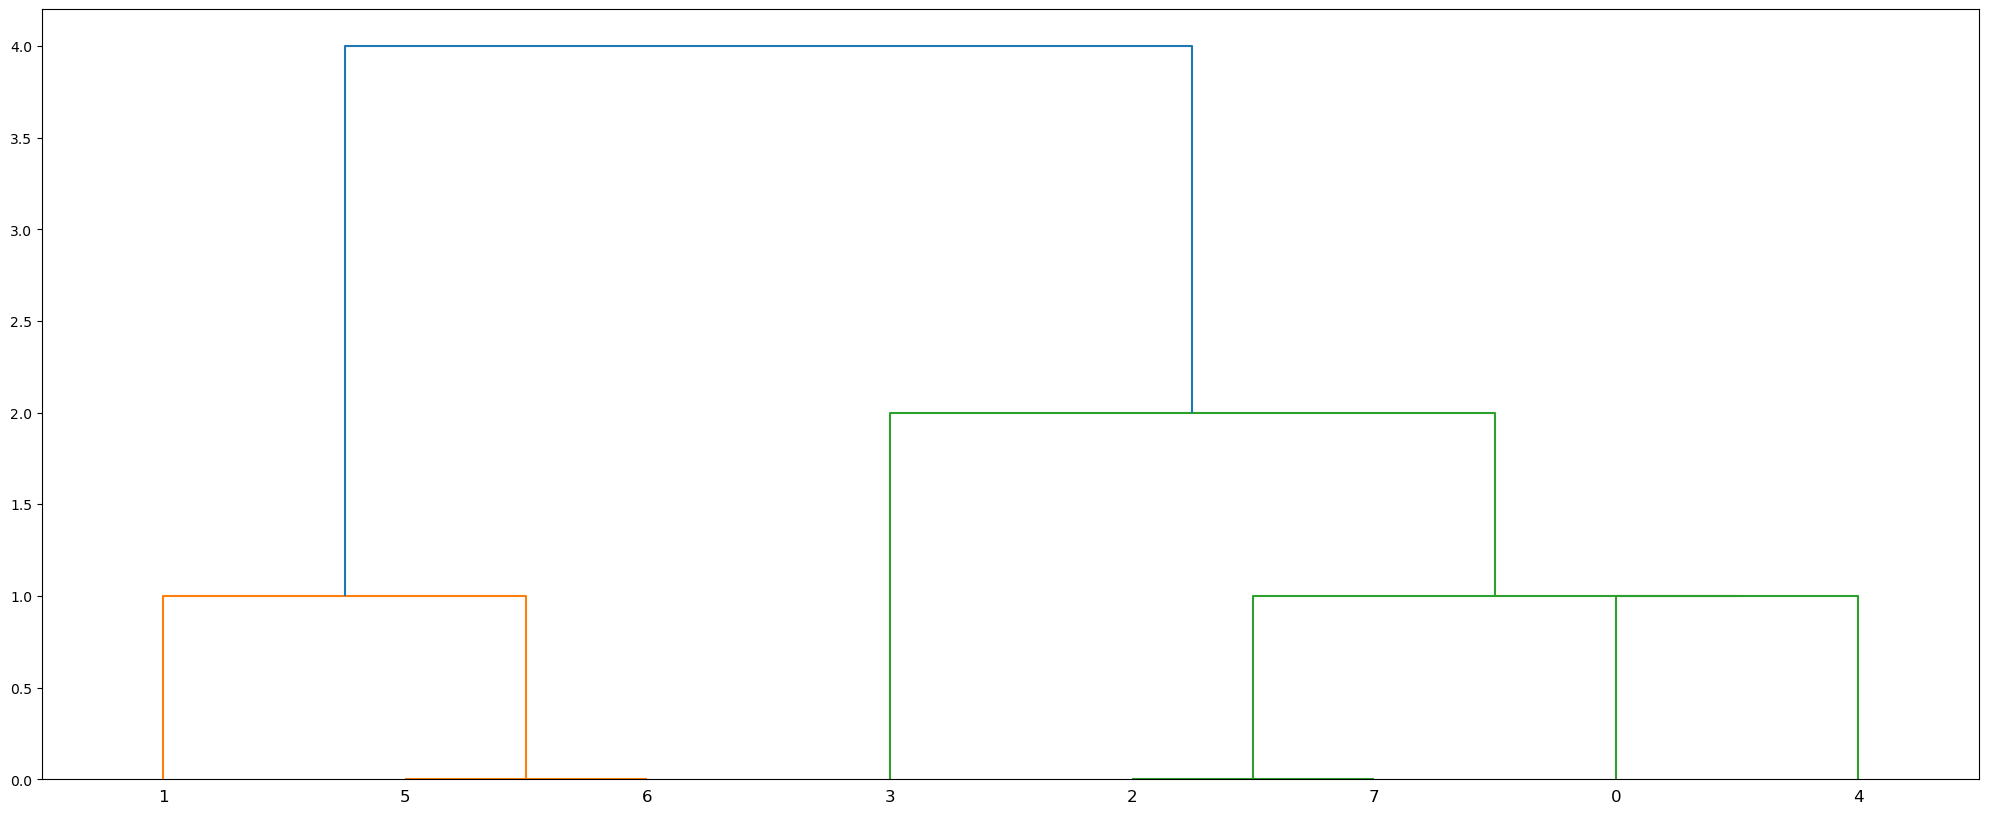

In [3]:
Z = linkage(X, 'single')

fig = plt.figure(figsize=(25, 10))

dn = dendrogram(Z)

plt.show()

In [4]:
Z

array([[ 2.,  7.,  0.,  2.],
       [ 5.,  6.,  0.,  2.],
       [ 0.,  4.,  1.,  2.],
       [ 8., 10.,  1.,  4.],
       [ 1.,  9.,  1.,  3.],
       [ 3., 11.,  2.,  5.],
       [12., 13.,  4.,  8.]])